In [1]:
include("../../startup.jl")
using DifferentialEquations
using NumericallyIntegrateArrays
using Distributions
using LaTeXStrings
using LsqFit
using Interpolations
using JLD2
using JuliaDB

In [2]:
@load "radiotrack.jld2" t meansd semsd stdsd
t_rt = t 
msd_rt = meansd;
sem_rt = semsd;
std_rt = stdsd;

In [3]:
function centreddiffusion2d!(du,u,p,t)
    D,h,n = p
    du[1] = (D/h^2)*(u[2]-u[1]) + (D/(2h^2))*(u[2]-u[1])
    for i = 2:n-1
        du[i] = (D/h^2)*(u[i-1]-2*u[i]+u[i+1]) + (D/(2i*h^2))*(u[i+1]-u[i-1])
    end
    du[n] = (D/h^2)*(u[n-1]-u[n]) + (D/(2n*h^2))*(u[n]-u[n-1])
end
    
function diffusion_sim2d(D, dt, u0, N, h, t, r)
    #us = [u0]
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    us = [u0]
    for (i,ts) in enumerate(t[1:(end-1)])
        prob = ODEProblem(centreddiffusion2d!,u0,tspan,(D,h,N))
        u0 = solve(prob, Euler(),dt=dt).u[end]
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us,[u0])
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int, us
end

function diffusions!(du,u,p,t)
    d,n = p
    du[1] = d*(u[2]-u[1])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1])
    end
    du[n] = d*(u[n-1]-u[n])
end


function diffusion_sim(d, dt, u0, N, t,x,dx)
    us = [u0]
    tspan = (0.0, dt)
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
        prob = ODEProblem(diffusions!,u0,tspan,(d,N))
        u0 = solve(prob).u[end]
        append!(msd,trapz(u0.*x.^2,dx))
        append!(us,[u0])
    end
    return msd, us
end



diffusion_sim (generic function with 1 method)

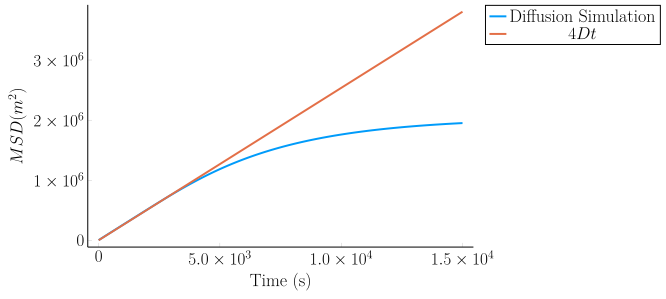

In [4]:
L = 2000
N = 50
h = L/N
D = 63.4#0.1h^2/2
d = D/h^2
u = zeros(N)
T = 15000
dt = (0.1h^2/2D)#1 

r = h:h:L
u0 = zeros(size(r))
u0[1] = 1/(2*pi*h)

tspan = (0.0, dt)

msd_diff, u_int, u =  diffusion_sim2d(D, dt, u0, N, h, dt:dt:T, r);
msd_diff1d,u1d =  diffusion_sim(d, dt, u0, N, dt:dt:T,r,h)#diffusion_sim1d(D, dt, u0, N, h, dt:dt:T, r);

p1 = plot(xlabel="Time (s)", ylabel=L"MSD (m^2)")
plot!(dt:dt:T,msd_diff, label="Diffusion Simulation")
plot!(dt:dt:T,4D*(dt:dt:T), label=L"4Dt")

#p2 = plot(xlabel="Time (s)", ylabel=L"\int u r dr")
#plot!(dt:dt:T,u_int, label="")

#plot(p1,p2,size=(800,500))
#savefig("../figs/2d_diffusion.png")

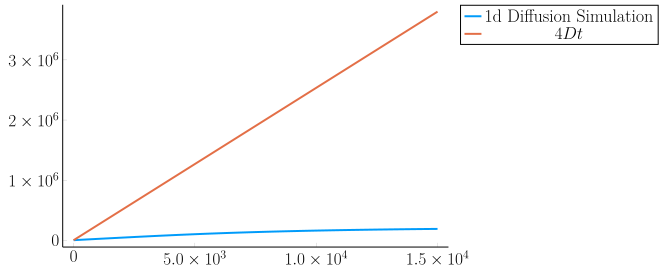

In [5]:
plot(dt:dt:T,msd_diff1d, label="1d Diffusion Simulation")
plot!(dt:dt:T,4D*(dt:dt:T), label=L"4Dt")

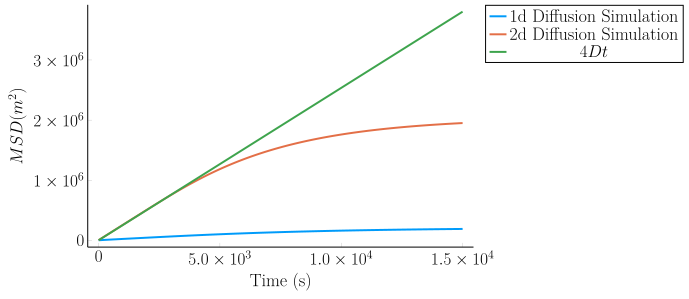

In [6]:
p1 = plot(xlabel="Time (s)", ylabel=L"MSD (m^2)")
plot!(dt:dt:T,msd_diff1d, label="1d Diffusion Simulation")
plot!(dt:dt:T,msd_diff, label="2d Diffusion Simulation")
plot!(dt:dt:T,4D*(dt:dt:T), label=L"4Dt")
#savefig("../figs/1d2d_diffusion.png")

In [4]:
function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function centreddiffusion2d!(du,u,p,t)
    D,h,n = p
    du[1] = (D/h^2)*(u[2]-u[1]) + (D/(2h^2))*(u[2]-u[1])
    for i = 2:n-1
        du[i] = (D/h^2)*(u[i-1]-2*u[i]+u[i+1]) + (D/(2i*h^2))*(u[i+1]-u[i-1])
    end
    du[n] = (D/h^2)*(u[n-1]-u[n]) + (D/(2n*h^2))*(u[n]-u[n-1])
end
    
function diffusion_sim2d(D, dt, u0, N, h, t, r)
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    us = [u0]
    for (i,ts) in enumerate(t[1:(end-1)])
        prob = ODEProblem(centreddiffusion2d!,u0,tspan,(D,h,N))
        u0 = solve(prob, Euler(),dt=dt).u[end]
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us,[u0])
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int, us
end

function domain_shrink2d(θ, D, dt,u0, N, h, t, tD, r)
    #print(θ[1], "  ", θ[2], "  ", size(t), "  ", h, "  ", div(θ[1],h), "\n")
    boxsize = zeros(Int, size(t))
    boxsize[t .<= θ[2]] .= div(θ[1],h)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./h))
    boxsize[boxsize.>div(θ[1],h)] .= div(θ[1],h)
    boxsize[boxsize .== 1] .= 2
    boxsize[end] = 1
   # print(boxsize)
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    for (i,ts) in enumerate(t[1:end-1])
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(centreddiffusion2d!,u0,tspan,(D,h,ns))
            u0 = solve(prob, Euler(),dt=dt).u[end]
        end
        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
                r = r[1:boxsize[i+1]]
            end
        end 
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int
end


function r2_test(x1,y1,x_model,y_model)
    sstot = 0 
    ssres = 0
    for (i,xi) in enumerate(x1)
        sstot += (y1[i]-mean(y1))^2
        ssres +=  (y_model[findfirst(x -> x==xi, x_model)]-y1[i])^2
    end 
    return 1 - ssres/sstot
end

r2_test (generic function with 1 method)

In [58]:
N = 200
D = 65
T = t_rt[end-6]
tD = 600.0

600.0

In [59]:
R_0s = 1200:50:1800
t_ss = 0:1000:5000

r2 = zeros(length(R_0s),length(t_ss))
    
@time for (i,R_0) in enumerate(R_0s)
    for (j,t_s) in enumerate(t_ss)
        h = R_0/N
        dt = (0.9h^2/2D)
        r = h:h:R_0    
        u0 = zeros(size(r))
        u0[1] = 1/(2*pi*h)
        T = t_rt[end]+dt
        t = dt:dt:T
        #print(length(t), "  ")
        msds, u_int = domain_shrink2d([R_0,t_s], D, dt,u0, N, h, t, tD, r);
        itp = interpolate((t,), msds, Gridded(Linear()))
        msd_itp = [ itp(ts) for ts in t_rt]
        r2[i,j] = r2_test(t_rt,msd_rt,t_rt,msd_itp)
    end
end

@save "test.jld2" R_0s t_ss r2
r2

1107.587123 seconds (2.35 G allocations: 264.331 GiB, 8.14% gc time)


13×6 Array{Float64,2}:
  0.346675   0.389212    0.429664   0.467099    0.50147     0.532691
  0.523265   0.560303    0.594911   0.626198    0.654104    0.678557
  0.667381   0.697382    0.724533   0.748006    0.767732    0.783665
  0.775942   0.797272    0.815246   0.82913     0.838838    0.844366
  0.846003   0.856947    0.863957   0.866383    0.864136    0.857258
  0.874874   0.873655    0.86783    0.856844    0.840608    0.819221
  0.860114   0.844904    0.824323   0.797915    0.765579    0.727493
  0.79958    0.768523    0.731223   0.687336    0.63674     0.579702
  0.691349   0.642566    0.586564   0.523107    0.452059    0.373763
  0.533873   0.465477    0.388788   0.303663    0.209944    0.108056
  0.325787   0.235914    0.136564   0.0276841  -0.0909074  -0.218723
  0.066172  -0.0470198  -0.170992  -0.305647   -0.451302   -0.607363
 -0.245864  -0.384178   -0.534661  -0.697149   -0.872003   -1.05854

In [3]:
@load "test.jld2" R_0s t_ss r2

3-element Array{Symbol,1}:
 :R_0s
 :t_ss
 :r2

In [4]:
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]
R_0, t_s

(1450, 0)

In [6]:
pgfplotsx()
#r2s = r2
#r2s[r2s.<0.8] .= 0.8
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]
plot(size=(300,200), grid=false, linewidth=2,
    tickfontsize=10, guidefontsize=10, legendfontsize=10, titlefontsize=10, margin=10mm)
heatmap!(R_0s, t_ss, r2', match_dimensions=true, xlabel=L"R_0",ylabel=L"t_s", colorbar_title=L"$R^2$ value", label=L"$R^2$ value")#,colorbar_titlefontsize=12)
scatter!([R_0,R_0],[t_s,t_s], label="", marker=:xcross, markersize=8, color=:black)
savefig("../figs/2dshrink_sweep.png")

In [57]:
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]

h = R_0/N
dt = (0.8h^2/2D)
r = h:h:R_0      
u0 = zeros(size(r))
u0[1] = 1/(2*pi*h)
t = dt:dt:T
msds, u_int = domain_shrink2d([R_0,t_s], D, dt,u0, N, h, t, tD, r); 
p1 = plot(xlabel="Time (hours)", ylabel=L"MSD (m^2)", legend=:topright)
plot!(t[100:1000:end]./3600,msds[100:1000:end], color=:blue, label="Shrinking diffusion")
scatter!(t_rt./3600,msd_rt, color=:red, label="Radiotracking data")
plot!(t_rt./3600,msd_rt, ribbon=sem_rt, fill=:orange, linewidth=0,
    markersize=8, color=:orange, label="Standard error")
savefig("../figs/2dshrink_result.png")

In [3]:
function diffusions!(du,u,p,t)
    d,n = p
    du[1] = d*(u[2]-u[1])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1])
    end
    du[n] = d*(u[n-1]-u[n])
end


function diffusion_sim(d, dt, u0, N, t)
    us = [u0]
    tspan = (0.0, dt)
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
        prob = ODEProblem(diffusions!,u0,tspan,(d,N))
        u0 = solve(prob).u[end]
        append!(msd,trapz(u0.*x.^2,dx))
        append!(us,[u0])
    end
    return msd, us
end

function convectiondiffusions!(du,u,p,t)
    d,n,c = p
    du[1] = d*(u[2]-u[1]) - c*(u[2])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1]) - c*(u[i+1]-u[i])
    end
    du[n] = d*(u[n-1]-u[n]) + c*(u[n])
end

function convection_diffusion_sim(d1, d2, c, dt, u0, N, t, tD)
    tspan = (0.0, dt)
    u0s = [u0]
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1]) 
        if ts < tD
            prob = ODEProblem(diffusions!,u0,tspan,(d1,N))
            u0 = solve(prob).u[end]
        else
            prob = ODEProblem(convectiondiffusions!,u0,tspan,(d2,N,c))
            u0 = solve(prob).u[end]
        end 
        append!(u0s, [u0])
        append!(msd,trapz(u0.*x.^2,dx))
    end
    return msd, u0s
end


convection_diffusion_sim (generic function with 1 method)

In [13]:
L = 2000
N = 50
h = L/N
D = 63.4#0.1h^2/2
u = zeros(N)
T = 15000
dt = (0.1h^2/2D)#1 

r = h:h:L
u0 = zeros(size(r))
u0[1] = 1/(2*pi*h)

tspan = (0.0, dt)

msd_diff, u_int, u =  diffusion_sim2d(D, dt, u0, N, h, dt:dt:T, r);
p1 = plot(xlabel="Time (s)", ylabel=L"MSD (m^2)")
plot!(dt:dt:T,msd_diff, label="Diffusion Simulation")
plot!(dt:dt:T,4D*(dt:dt:T), label=L"4Dt")

p2 = plot(xlabel="Time (s)", ylabel=L"\int u r dr")
plot!(dt:dt:T,u_int, label="")

plot(p1,p2,size=(800,500))
#savefig("../figs/2d_diffusion.png")


L = 2000
N = 100
dx = div(L,N)
D1 = 65#100
d1 = 2D1/dx^2
u = zeros(N)
tD = 4350
T = 3600*4
dt = 10.0
D2 = 20
d2 = 2D2/dx^2
chi = - 0.15
c = chi/dx
#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx

tspan = (0.0, dt)

msd_diff, u =  diffusion_sim(d1, dt, u0, N, dt:dt:T);
t_rt = dt:dt:T

10.0:10.0:14400.0

In [14]:
anim = @animate for i = 1:1440
    a = plot(x[1:length(u[i])],u[i], xlabel="x (m)", ylabel=L"\phi", legend=false, xlim=(0,L),ylim=(0,maximum(u[20])))
    b  = plot((t_rt[1:i])./3600, msd_diff[1:i]./1e6, xlabel="Time (hours)",  ylabel="MSD (km²)", legend=false, xlim=(0,4), ylim=(0,maximum(msd_diff)./1e6))
    plot(a,b, layout = @layout([a b]), size = (1200,600))
end
mp4(anim, "../figs/diffusion.mp4", fps = 100)

┌ Info: Saved animation to 
│   fn = C:\Users\lucy_\bats\radiotrack\figs\diffusion.mp4
└ @ Plots C:\Users\lucy_\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\lucy_\\bats\\radiotrack\\figs\\diffusion.mp4")

In [9]:
plot(xlabel=L"$r$ (m)",ylabel=L"\phi")
plot!(x, u, label=L"$t = 1$ hour")
msd_diff, u2 =  diffusion_sim(d1, dt, u, N, dt:dt:T)
plot!(x, u2, label=L"$t = 2$ hours")
msd_diff, u3 =  diffusion_sim(d1, dt, u2, N, dt:dt:T)
plot!(x, u3, label=L"$t = 3$ hours")
msd_diff, u5 =  diffusion_sim(d1, dt, u3, N, dt:dt:T)
plot!(x, u5, label=L"$t = 5$ hours")
savefig("../figs/discretised_phi.png")

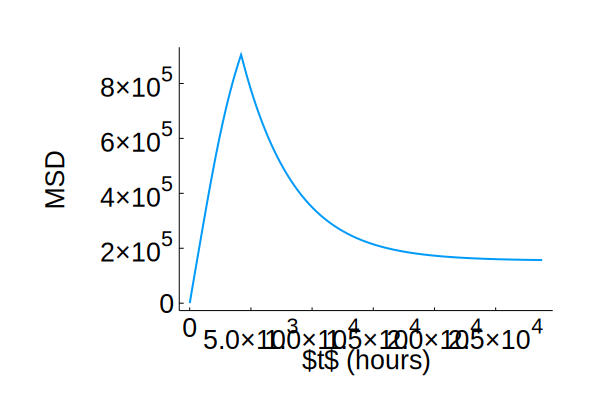

In [10]:
L = 2000
N = 100
dx = div(L,N)
D1 = 63.4
d1 = 2*D1/dx^2
u = zeros(N)
tD = 4200
T = 3600*8
dt = 10.0
D2 = 40.0
d2 = D2/dx^2
chi = - 0.15
c = chi/dx
#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx
tspan = (0.0, dt)

msd_diff =  diffusion_sim(d1, dt, u0, N, dt:dt:T)
msd_cd,u0s = convection_diffusion_sim(d1, d2, c, dt, u0, N,dt:dt:T, tD)
plot(xlabel=xlabel=L"$t$ (hours)", ylabel="MSD")
plot!((dt:dt:T),msd_cd,label="", linewidth=2)
#savefig("../figs/convection_diffusion_MSD.png")

In [12]:
t_rt = dt:dt:T
anim = @animate for i = 1:2880
    a = plot(x[1:length(u0s[i])],u0s[i], xlabel="x (m)", ylabel=L"\phi", legend=false, xlim=(0,L),ylim=(0,maximum(u0s[20])))
    b  = plot((t_rt[1:i])./3600, msd_cd[1:i]./1e6, xlabel="Time (hours)",  ylabel="MSD (km²)", legend=false, xlim=(0,8), ylim=(0,maximum(msd_cd)./1e6))
    plot(a,b, layout = @layout([a b]), size = (1200,600))
end
mp4(anim, "../figs/convectiondiffusion.mp4", fps = 100)

┌ Info: Saved animation to 
│   fn = C:\Users\lucy_\bats\radiotrack\figs\convectiondiffusion.mp4
└ @ Plots C:\Users\lucy_\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\lucy_\\bats\\radiotrack\\figs\\convectiondiffusion.mp4")

In [113]:
plot(xlabel=L"$r$ (m)",ylabel=L"\phi")
plot!(u0s[360],label=L"$t = 0$ hours")
plot!(u0s[360+72],label=L"$t = 0.2$ hours")
#plot!(u0s[360+180],label=L"$t = 0.5$ hours")
plot!(u0s[360+2*360],label=L"$t = 2$ hours")
plot!(u0s[2880],label=L"$t = 8$ hours")
savefig("../figs/convection_diffusion.png")

In [4]:
function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function domain_shrink(θ, d, dt,u0, t, tD)
    u0s = [u0]
    boxsize = zeros(Int, size(t))
    #print("t_rt = ", t_rt, "\n\n θ[2] = ", θ[2])
   # print(θ[2])
    boxsize[t .<= θ[2]] .= L/dx
   # print(boxsize)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./dx))
    boxsize[boxsize.>L/dx] .= L/dx
    boxsize[end] = 1
  #  print(boxsize)
    tspan = (0.0, dt)
    msd = [trapz(u0.*x[1:size(u0)[1]].^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
      #  print(i,"\n")
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(diffusions!,u0,tspan,(d,ns))
            u0 = solve(prob).u[end]
        end
        append!(msd,trapz(u0.*x[1:length(u0)].^2,dx))

        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
            end
        end 
        append!(u0s, [u0])
    end
    return msd, u0s
end

domain_shrink (generic function with 1 method)

In [6]:
L = 2000
N = 1000
dx = div(L,N)
D = 63.4#5062.87
d = D/dx^2
u = zeros(N)
T = t_rt[end]
dt = 10.0#100.0
tD = 00.0

#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx


prior = [Uniform(2.5e6,4e6), Uniform(0.0,7.2e3)]
R_0 = 1755.6
t_s = 901
@time msds, u0s = domain_shrink([R_0,t_s],d,dt,u0,dt:dt:T,tD);

352.088244 seconds (52.23 M allocations: 28.161 GiB, 1.07% gc time)


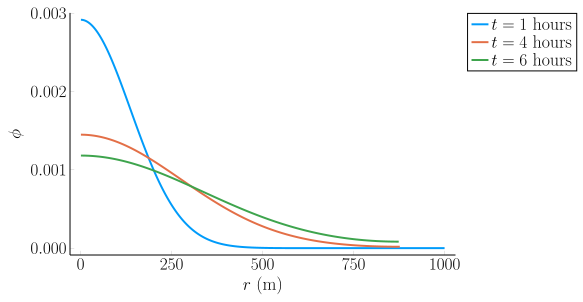

In [75]:
pgfplotsx()
plot(xlabel=L"$r$ (m)",ylabel=L"\phi")
plot!(u0s[60], label=L"$t = 1$ hours")
plot!(u0s[240], label=L"$t = 4$ hours")
plot!(u0s[360], label=L"$t = 6$ hours")

In [9]:
gr()
anim = @animate for i=1:length(msds)
    a = plot(x[1:length(u0s[i])],u0s[i], xlabel="x (m)", ylabel=L"\phi", legend=false, xlim=(0,L),ylim=(0,maximum(u0s[20])))
    b  = plot((dt:dt:T)[1:i]./3600, msds[1:i]./1e6, xlabel="Time (hours)",  ylabel="MSD (km²)", legend=false, xlim=(0,8), ylim=(0,maximum(msds)./1e6))
    plot(a,b, layout = @layout([a b]), size = (1200,600))
end
mp4(anim, "../figs/shrink.mp4", fps = 100)

┌ Info: Saved animation to 
│   fn = C:\Users\lucy_\bats\radiotrack\figs\shrink.mp4
└ @ Plots C:\Users\lucy_\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\lucy_\\bats\\radiotrack\\figs\\shrink.mp4")

In [23]:
@save "shrink_bound.jld2" t_rt msds u0s x L

In [90]:
@load "shrink_bound.jld2" t_rt msds 

2-element Array{Symbol,1}:
 :t_rt
 :msds

In [97]:
plot(xlabel="Time (hours)",ylabel="MSD (km²)")
plot!(t_rt./3600,msds./1e6, label="Shrinking Domain")
plot!((10:10:28800)./3600,msd_cd./1e6, label="Convection-Diffusion")
savefig("../figs/msd_comparison.png")